In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

#Visualization Tools

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# AI Workflow Module
from model_classifier import ModelClassifier, CustomClassifier

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.feature_selection import ColumnSelector

# Use for saving model 
import joblib

# Environment Parameters

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100 
plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
clinical_df = pd.read_csv('../../data/Clinical/SKCM_DATA_Clinical.csv', index_col = 0)
clinical_df.set_index('submitter_id',inplace=True)
clinical_df = clinical_df[~clinical_df.index.duplicated(keep='first')]
clinical_df = clinical_df[clinical_df.sample_type != "Solid Tissue Normal"]
print(clinical_df.shape)
clinical_df.head()

(469, 73)


,synchronous_malignancy,ajcc_pathologic_stage,tumor_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,primary_diagnosis,age_at_diagnosis,updated_datetime,prior_malignancy,year_of_diagnosis,prior_treatment,state,days_to_last_known_disease_status,ajcc_staging_system_edition,ajcc_pathologic_t,days_to_recurrence,morphology,ajcc_pathologic_n,ajcc_pathologic_m,classification_of_tumor,diagnosis_id,icd_10_code,site_of_resection_or_biopsy,tumor_grade,progression_or_recurrence,cigarettes_per_day,alcohol_history,exposure_id,years_smoked,weight,alcohol_intensity,height,bmi,race,gender,ethnicity,vital_status,age_at_index,days_to_birth,year_of_birth,demographic_id,year_of_death,days_to_death,treatments_pharmaceutical_treatment_intent_type,treatments_pharmaceutical_treatment_id,treatments_pharmaceutical_treatment_type,treatments_pharmaceutical_therapeutic_agents,treatments_pharmaceutical_treatment_or_therapy,treatments_pharmaceutical_days_to_treatment_end,treatments_pharmaceutical_days_to_treatment_start,treatments_pharmaceutical_regimen_or_line_of_therapy,treatments_pharmaceutical_treatment_effect,treatments_pharmaceutical_initial_disease_status,treatments_pharmaceutical_treatment_anatomic_site,treatments_pharmaceutical_treatment_outcome,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_id,treatments_radiation_treatment_type,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_days_to_treatment_end,treatments_radiation_days_to_treatment_start,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_initial_disease_status,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode,disease,sample_type
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-BF-A1PZ,No,Stage IIB,stage iib,0.0,NaN,not reported,"Skin, NOS",853.0,"Malignant melanoma, NOS",26240.0,2019-08-08T17:29:28.028808-05:00,no,2010.0,No,released,NaN,7th,T4a,NaN,8720/3,N0,M0,not reported,58877acc-4579-5cbc-b0d7-a1a60f9d9360,C44.9,"Skin, NOS",not reported,not reported,NaN,Not Reported,3224ecb7-496a-52b2-bb06-79faa29362bd,NaN,56.0,NaN,163.0,21.077195,white,female,not hispanic or latino,Alive,71.0,-26240.0,1939.0,a951cc17-255b-52c1-8b16-06a110a1f256,NaN,NaN,NaN,a738fcf5-fbc5-54ae-9aca-a474c981980b,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606f9d0c-405a-51a7-83b6-850abd587e3e,"Radiation Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-BF-A1PZ,SKCM,Primary Tumor
TCGA-HR-A5NC,No,NaN,not reported,0.0,NaN,not reported,"Skin, NOS",0.0,"Malignant melanoma, NOS",32872.0,2019-08-08T17:32:34.888606-05:00,no,NaN,No,released,NaN,6th,T4,NaN,8720/3,NX,M0,not reported,0a71cde5-a658-58fa-8f7d-5b461ed5ba0d,C44.5,Skin of trunk,not reported,not reported,NaN,Not Reported,6f513e61-8df3-557c-8970-79ed709b496c,NaN,NaN,NaN,152.0,NaN,not reported,female,not reported,Alive,90.0,-32872.0,NaN,2bf37b46-b292-5211-8308-8e7478e13fac,NaN,NaN,NaN,0a4cb88c-3f7d-58b9-861e-4e99f1e79879,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5bec652c-8fcf-5693-ba5f-a4c685cfbafd,"Radiation Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-HR-A5NC,SKCM,Primary Tumor
TCGA-EE-A183,No,Stage 0,stage 0,0.0,NaN,not reported,"Skin, NOS",NaN,"Malignant melanoma, NOS",17788.0,2019-08-08T17:31:00.525265-05:00,no,2007.0,No,released,NaN,6th,Tis,NaN,8720/3,N0,M0,not reported,ad50acaa-3906-5038-a738-b1df7206c3fb,C77.3,Lymph nodes of axilla or arm,not reported,not reported,NaN,Not Reported,5e224124-5dc5-5e14-a52d-aebafebbdae1,NaN,NaN,NaN,NaN,NaN,white,male,not hispanic or latino,Dead,48.0,-17788.0,1959.0,f890ebbe-7014-5316-9088-92d883eb8050,2009.0,818.0,NaN,2ac616a8-887f-53c2-a8ea-ae66c6d48a02,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f7775347-3381-519c-b1fd-c61f6d261154,"Radiation Therapy, NOS"

In [3]:
train_df = pd.read_csv('../data/TCGA-SKCM_train_unresampled_v0.csv',index_col=0)
train_df.head()

,sample_type,weight,height,bmi,age_at_index,A1BG,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,ACP2,ACP5,ACPP,ACRV1,ACTA1,ACTA2,ACTG1,ACTG1.1,ACTC1,ACTG1.2,ACTG1.3,ACTG2,ACTN4,ACTL6A,ACTN1,ACTN2,ACTN3,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ACY1,ACYP1,ACYP2,ADA,ADAM8,ADAM10,ADAR,ADARB1,ADARB2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,ADCY8,ADCY9,ADCYAP1,ADCYAP1R1,ADD1,ADD2,ADD3,PLIN2,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,ADH7,ADK,ADM,ADORA1,ADORA2A,ADORA2B,ADORA3,ADPRH,PARP1,PARP4,ADRA1D,ADRA1B,ADRA1A,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADSL,ADSS,AP2A1,AP2A2,AP1B1,AP2B1,AP1G1,AEBP1,AES,AFG3L1P,AFM,AFP,AGA,ACAN,AGER,AGL,AGRP,JAG1,AGT,AGTR1,AGTR2,APLNR,AGXT,NR0B1,AHCY,AHR,AHSG,AIF1,AIM1,AK1,RP4-592A1.2,AK4,AKT1,AKT2,ALAD,ALAS1,ALAS2,ALB,ALCAM,ABCD1,ALDH1A1,ALDH2,ALDH3A1,ALDH1B1,ALDH1A3,ALDH3B1,ALDH3B2,ALDH9A1,ALDH3A2,ABCD2,ALDOA,ALDOB,ALDOC,AKR1B1,ALK,ALOX12,ALOX5,ALOX5AP,ALOX12B,ANXA8L2,ANXA8L2.1,ALOX15,ALOX15B,ALPI,ALPL,ALPP,ALPPL2,ALX3,AMBN,AMBP,AMD1,AMELX,AMELY,AMFR,AMH,AMHR2,AMPD1,AMPD2,AMPD3,AMPH,BIN1,AMT,AMY1A,AMY2A,AMY2B,AMY2B.1,ANG,ANGPT1,ANGPT2,ANK1,ANK2,ANK3,ANPEP,SLC25A4,SLC25A5,SLC25A6,ANXA1,ANXA2,ANXA2P2,ANXA3,ANXA4,ANXA5,ANXA6,ANXA7,ANXA11,ANXA13,AOAH,AOC2,AOX1,APAF1,NUDT2,APOF,APBA1,APBA2,APBB1,APBB2,APC,APCS,AIRE,APEH,APEX1,BIRC2,BIRC3,RP11-566F5.1,BIRC5,APLP1,APLP2,APOA1,APOA2,APOA4,APOB,APOC1,APOC1P1,...,RP4-740C4.6,RP11-67L2.2,FAM47E,CCDC152,ZNF737,URAHP,HSFX2,SNAP47.2,SNAP47.3,CCDC166,C17orf107,RP11-193H5.1,LINC00552,CECR7,NFYC-AS1,LINC00910,CXorf64,AC074286.1,CECR5-AS1,LRRC70,LRRC69,SPON2.2,SPON2.3,PSORS1C3,SMIM6,SYCE1L,C7orf72,BSPH1,TSTD1,CCDC183-AS1,TMEM194B,SP9,LINC00893,CD300LD,DBIL5P,AC016629.8,FAM83A-AS1,LINC00271,UBE2DNL,ZNF717,FAM196B,RRN3P3,FAM66E,AC009501.4,NPIPB5.2,NPIPB5.3,TEKT4P2,CLUHP3,KRTAP4-9,GAGE12J.20,GAGE12J.21,GAGE12J.22,GAGE12J.23,GAGE12J.24,NBPF10,FCGR1B,KRTAP4-7,CYP4F30P,DCAF13P3,RP11-169L17.5,PMS2P5.2,PMS2P5.3,FAM66D,FAM182B.3,FAM182B.4,FAM182B.5,GOLGA8EP,GOLGA8EP.1,FAM95B1,FAM182B.6,FAM182B.7,FAM182B.8,UBE2Q2P2,UBE2Q2P2.1,SPANXB2,FAM66A,LINC00240,SBF1P1,MRPL23-AS1,LINC01134,RP11-273G15.2,AC129778.2,UXT-AS1,AC016700.5,MAP3K14-AS1,JHDM1D-AS1,LINC01119,Z97634.3,NDUFB2-AS1,UBE2Q2P2.2,UBE2Q2P2.3,TEN1,POLR2J3.6,POLR2J3.7,POLR2J3.8,C17orf99,CHKB-AS1,LINC00930,KLLN,RNU4ATAC,SCARNA9.2,SCARNA9.3,SRRM5,C19orf69,C17orf96,PRICKLE4.2,PRICKLE4.3,LINC00426,LINC00092,DNMBP-AS1,DCTN1-AS1,RAMP2-AS1,TPT1-AS1,RP11-474D1.3,C5orf52,C2CD4D,ZFHX4-AS1,XXbac-B476C20.17,LINC00704,PCED1B-AS1,RP11-834C11.6,RP11-834C11.7,CTC-308K20.1,RP5-1068E13.7,ARHGEF33,AL121656.5,CTD-2547E10.2.2,CTD-2547E10.2.3,MEF2B,CMC4,LINC00894,BCDIN3D-AS1,LINC00173,ANKRD66,ULK4P1,WASH2P.6,WASH2P.7,WASH2P.8,FRG2C,ZNF605,RP11-55K22.5,RASAL2-AS1,LINC00882,FTX,TICAM2.2,TICAM2.3,SLC25A5-AS1,ajcc_pathologic_stage_Stage 0,ajcc_pathologic_stage_Stage I,ajcc_pathologic_stage_Stage IA,ajcc_pathologic_stage_Stage IB,ajcc_pathologic_stage_Stage II,ajcc_pathologic_stage_Stage IIA,ajcc_pathologic_stage_Stage IIB,ajcc_pathologic_stage_Stage IIC,ajcc_pathologic_stage_Stage III,ajcc_pathologic_stage_Stage IIIA,ajcc_pathologic_stage_Stage IIIB,ajcc_pathologic_stage_Stage IIIC,ajcc_pathologic_stage_Stage IV,tumor_stage_stage 0,tumor_stage_stage i,tumor_stage_stage ia,tumor_stage_stage ib,tumor_stage_stage ii,tumor_stage_stage iia,tumor_stage_stage iib,tumor_stage_stage iic,tumor_stage_stage iii,tumor_stage_stage iiia,tumor_stage_stage iiib,tumor_stage_stage iiic,tumor_stage_stage iv,ajcc_pathologic_t_T1,ajcc_pathologic_t_T1a,ajcc_pathologic_t_T1b,ajcc_pathologic_t_T2,ajcc_pathologic_t_T2a,ajcc_pathologic_t_T2b,ajcc_pathologic_t_T3,ajcc_pathologic_t_T3a,ajcc_pathologic_t_T3b,ajcc_pathologic_t_T4,ajcc_pathologic_t_T4a,ajcc_pathologic_t_T4b,ajcc_pathologic_t_TX,ajcc_pathologic_t_Tis,ajcc_pathologic_n_N1,ajcc_pathologic_n_N1a,ajcc_pathologic_n_N1b,ajcc_pathologic_n_N2,ajcc_pathologic_n_N

In [4]:
test_df = pd.read_csv('../data/TCGA-SKCM_test_unresampled_v0.csv',index_col=0)
test_df.head()

,sample_type,weight,height,bmi,age_at_index,A1BG,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,ACP2,ACP5,ACPP,ACRV1,ACTA1,ACTA2,ACTG1,ACTG1.1,ACTC1,ACTG1.2,ACTG1.3,ACTG2,ACTN4,ACTL6A,ACTN1,ACTN2,ACTN3,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ACY1,ACYP1,ACYP2,ADA,ADAM8,ADAM10,ADAR,ADARB1,ADARB2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,ADCY8,ADCY9,ADCYAP1,ADCYAP1R1,ADD1,ADD2,ADD3,PLIN2,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,ADH7,ADK,ADM,ADORA1,ADORA2A,ADORA2B,ADORA3,ADPRH,PARP1,PARP4,ADRA1D,ADRA1B,ADRA1A,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADSL,ADSS,AP2A1,AP2A2,AP1B1,AP2B1,AP1G1,AEBP1,AES,AFG3L1P,AFM,AFP,AGA,ACAN,AGER,AGL,AGRP,JAG1,AGT,AGTR1,AGTR2,APLNR,AGXT,NR0B1,AHCY,AHR,AHSG,AIF1,AIM1,AK1,RP4-592A1.2,AK4,AKT1,AKT2,ALAD,ALAS1,ALAS2,ALB,ALCAM,ABCD1,ALDH1A1,ALDH2,ALDH3A1,ALDH1B1,ALDH1A3,ALDH3B1,ALDH3B2,ALDH9A1,ALDH3A2,ABCD2,ALDOA,ALDOB,ALDOC,AKR1B1,ALK,ALOX12,ALOX5,ALOX5AP,ALOX12B,ANXA8L2,ANXA8L2.1,ALOX15,ALOX15B,ALPI,ALPL,ALPP,ALPPL2,ALX3,AMBN,AMBP,AMD1,AMELX,AMELY,AMFR,AMH,AMHR2,AMPD1,AMPD2,AMPD3,AMPH,BIN1,AMT,AMY1A,AMY2A,AMY2B,AMY2B.1,ANG,ANGPT1,ANGPT2,ANK1,ANK2,ANK3,ANPEP,SLC25A4,SLC25A5,SLC25A6,ANXA1,ANXA2,ANXA2P2,ANXA3,ANXA4,ANXA5,ANXA6,ANXA7,ANXA11,ANXA13,AOAH,AOC2,AOX1,APAF1,NUDT2,APOF,APBA1,APBA2,APBB1,APBB2,APC,APCS,AIRE,APEH,APEX1,BIRC2,BIRC3,RP11-566F5.1,BIRC5,APLP1,APLP2,APOA1,APOA2,APOA4,APOB,APOC1,APOC1P1,...,RP4-740C4.6,RP11-67L2.2,FAM47E,CCDC152,ZNF737,URAHP,HSFX2,SNAP47.2,SNAP47.3,CCDC166,C17orf107,RP11-193H5.1,LINC00552,CECR7,NFYC-AS1,LINC00910,CXorf64,AC074286.1,CECR5-AS1,LRRC70,LRRC69,SPON2.2,SPON2.3,PSORS1C3,SMIM6,SYCE1L,C7orf72,BSPH1,TSTD1,CCDC183-AS1,TMEM194B,SP9,LINC00893,CD300LD,DBIL5P,AC016629.8,FAM83A-AS1,LINC00271,UBE2DNL,ZNF717,FAM196B,RRN3P3,FAM66E,AC009501.4,NPIPB5.2,NPIPB5.3,TEKT4P2,CLUHP3,KRTAP4-9,GAGE12J.20,GAGE12J.21,GAGE12J.22,GAGE12J.23,GAGE12J.24,NBPF10,FCGR1B,KRTAP4-7,CYP4F30P,DCAF13P3,RP11-169L17.5,PMS2P5.2,PMS2P5.3,FAM66D,FAM182B.3,FAM182B.4,FAM182B.5,GOLGA8EP,GOLGA8EP.1,FAM95B1,FAM182B.6,FAM182B.7,FAM182B.8,UBE2Q2P2,UBE2Q2P2.1,SPANXB2,FAM66A,LINC00240,SBF1P1,MRPL23-AS1,LINC01134,RP11-273G15.2,AC129778.2,UXT-AS1,AC016700.5,MAP3K14-AS1,JHDM1D-AS1,LINC01119,Z97634.3,NDUFB2-AS1,UBE2Q2P2.2,UBE2Q2P2.3,TEN1,POLR2J3.6,POLR2J3.7,POLR2J3.8,C17orf99,CHKB-AS1,LINC00930,KLLN,RNU4ATAC,SCARNA9.2,SCARNA9.3,SRRM5,C19orf69,C17orf96,PRICKLE4.2,PRICKLE4.3,LINC00426,LINC00092,DNMBP-AS1,DCTN1-AS1,RAMP2-AS1,TPT1-AS1,RP11-474D1.3,C5orf52,C2CD4D,ZFHX4-AS1,XXbac-B476C20.17,LINC00704,PCED1B-AS1,RP11-834C11.6,RP11-834C11.7,CTC-308K20.1,RP5-1068E13.7,ARHGEF33,AL121656.5,CTD-2547E10.2.2,CTD-2547E10.2.3,MEF2B,CMC4,LINC00894,BCDIN3D-AS1,LINC00173,ANKRD66,ULK4P1,WASH2P.6,WASH2P.7,WASH2P.8,FRG2C,ZNF605,RP11-55K22.5,RASAL2-AS1,LINC00882,FTX,TICAM2.2,TICAM2.3,SLC25A5-AS1,ajcc_pathologic_stage_Stage 0,ajcc_pathologic_stage_Stage I,ajcc_pathologic_stage_Stage IA,ajcc_pathologic_stage_Stage IB,ajcc_pathologic_stage_Stage II,ajcc_pathologic_stage_Stage IIA,ajcc_pathologic_stage_Stage IIB,ajcc_pathologic_stage_Stage IIC,ajcc_pathologic_stage_Stage III,ajcc_pathologic_stage_Stage IIIA,ajcc_pathologic_stage_Stage IIIB,ajcc_pathologic_stage_Stage IIIC,ajcc_pathologic_stage_Stage IV,tumor_stage_stage 0,tumor_stage_stage i,tumor_stage_stage ia,tumor_stage_stage ib,tumor_stage_stage ii,tumor_stage_stage iia,tumor_stage_stage iib,tumor_stage_stage iic,tumor_stage_stage iii,tumor_stage_stage iiia,tumor_stage_stage iiib,tumor_stage_stage iiic,tumor_stage_stage iv,ajcc_pathologic_t_T1,ajcc_pathologic_t_T1a,ajcc_pathologic_t_T1b,ajcc_pathologic_t_T2,ajcc_pathologic_t_T2a,ajcc_pathologic_t_T2b,ajcc_pathologic_t_T3,ajcc_pathologic_t_T3a,ajcc_pathologic_t_T3b,ajcc_pathologic_t_T4,ajcc_pathologic_t_T4a,ajcc_pathologic_t_T4b,ajcc_pathologic_t_TX,ajcc_pathologic_t_Tis,ajcc_pathologic_n_N1,ajcc_pathologic_n_N1a,ajcc_pathologic_n_N1b,ajcc_pathologic_n_N2,ajcc_pathologic_n_N

In [5]:
# Get PPI genes
ppi_features_df = pd.read_csv('../data/skcm_ppi_betweenness_centrality.csv', index_col=0)

top10_ppi_features = ppi_features_df.betweenness_centrality.head(10).index.values
top20_ppi_features = ppi_features_df.betweenness_centrality.head(20).index.values

ppi_features_df.head(10)

,betweenness_centrality
PC,0.088636
RPN2,0.063636
TSHR,0.049026
GSR,0.039610
RPS28,0.037013
GRIK5,0.018506
GNG2,0.012987
C7,0.012987
S100A7,0.010390
SERPINB4,0.007792


In [6]:
# Get RF genes
rf_features_df = pd.read_csv('../data/Melanoma_RF_weights_all_genomic_data.csv',index_col=0)

top10_rf_features = rf_features_df.weights.head(10).index.values
top20_rf_features = rf_features_df.weights.head(20).index.values
top30_rf_features = rf_features_df.weights.head(30).index.values

rf_features_df.head(10)

,weights
C7,0.159056
KRT17,0.102874
CLEC2A,0.091171
S100A7A,0.064637
KRTDAP,0.060437
WFDC5,0.041753
KRT6B,0.038876
S100A7,0.024198
KRT14,0.019587
PVRL4,0.017585


In [7]:
# Load the models

rf_lr_10_model       = joblib.load('melanoma_rf_lr_10_genes_classifier.pkl')
rf_svm_lin_10_model  = joblib.load('melanoma_rf_svm_10_genes_classifier.pkl')
rf_svm_sig_30_model  = joblib.load('melanoma_rf_svm_sig_30_genes_classifier.pkl')
rf_nb_10_model       = joblib.load('melanoma_rf_nb_10_genes_classifier.pkl')
rf_rf_20_model       = joblib.load('melanoma_rf_rf_20_genes_classifier.pkl')

ppi_lr_10_model       = joblib.load('melanoma_ppi_lr_10_genes_classifier.pkl')
ppi_svm_lin_20_model  = joblib.load('melanoma_ppi_svm_lin_20_genes_classifier.pkl')
ppi_svm_sig_10_model  = joblib.load('melanoma_ppi_svm_sig_10_genes_classifier.pkl')
ppi_nb_20_model       = joblib.load('melanoma_ppi_nb_20_genes_classifier.pkl')

In [8]:
# Setup pipeline

rf_lr_10_model_pipe       = make_pipeline(
                               ColumnSelector(cols=tuple(top10_rf_features)),
                               rf_lr_10_model
                            )
rf_svm_lin_10_model_pipe = make_pipeline(
                            ColumnSelector(cols=tuple(top10_rf_features)),
                            rf_svm_lin_10_model
                         )
rf_svm_sig_30_model_pipe  = make_pipeline(
                            ColumnSelector(cols=tuple(top30_rf_features)),
                            rf_svm_sig_30_model
                         )
rf_nb_10_model_pipe      = make_pipeline(
                            ColumnSelector(cols=tuple(top10_rf_features)),
                            rf_nb_10_model
                         )
rf_rf_20_model_pipe      = make_pipeline(
                            ColumnSelector(cols=tuple(top20_rf_features)),
                            rf_nb_10_model
                         )

ppi_lr_10_model_pipe     = make_pipeline(
                            ColumnSelector(cols=tuple(top10_ppi_features)),
                            ppi_lr_10_model
                         )
ppi_svm_lin_20_model_pipe = make_pipeline(
                            ColumnSelector(cols=tuple(top20_ppi_features)),
                            ppi_svm_lin_20_model
                         )
ppi_svm_sig_10_model_pipe  = make_pipeline(
                            ColumnSelector(cols=tuple(top10_ppi_features)),
                            ppi_svm_sig_10_model
                         )
ppi_nb_20_model_pipe    = make_pipeline(
                            ColumnSelector(cols=tuple(top20_ppi_features)),
                            ppi_nb_20_model
                         )

all_pipelines = [
        rf_lr_10_model_pipe,
        rf_svm_lin_10_model_pipe,
        rf_svm_sig_30_model_pipe,
        rf_nb_10_model_pipe,
        rf_rf_20_model_pipe,
        ppi_lr_10_model_pipe,
        ppi_svm_lin_20_model_pipe,
        ppi_svm_sig_10_model_pipe, 
        ppi_nb_20_model_pipe
]

rf_pipelines = [
        rf_lr_10_model_pipe,
        rf_svm_lin_10_model_pipe,
        rf_svm_sig_30_model_pipe,
        rf_nb_10_model_pipe
]

ppi_pipelines = [
        ppi_lr_10_model_pipe,
        ppi_svm_lin_20_model_pipe,
        ppi_svm_sig_10_model_pipe, 
        ppi_nb_20_model_pipe
]

significant_pipelines = [
        rf_lr_10_model_pipe,
        rf_rf_20_model_pipe,
        ppi_svm_sig_10_model_pipe
]

In [9]:
model_classifier = ModelClassifier(
    train = train_df, 
    validation = test_df, 
    label = 'sample_type', 
    label_values = ['Primary Tumor', 'Metastatic'],
    features = train_df.columns.values, 
    label_binarizer = False)

In [10]:
ensemble_all_clf = EnsembleVoteClassifier(clfs=all_pipelines, voting='soft')
ensemble_rf_clf = EnsembleVoteClassifier(clfs =rf_pipelines, voting='soft')
ensemble_ppi_clf = EnsembleVoteClassifier(clfs=ppi_pipelines, voting='soft')
ensemble_sig_clf = EnsembleVoteClassifier(clfs=significant_pipelines, voting='soft')

In [11]:
ensemble_all_clf.fit(model_classifier.train_features, model_classifier.train_labels)

EnsembleVoteClassifier(clfs=[Pipeline(steps=[('columnselector',
                                              ColumnSelector(cols=('C7',
                                                                   'KRT17',
                                                                   'CLEC2A',
                                                                   'S100A7A',
                                                                   'KRTDAP',
                                                                   'WFDC5',
                                                                   'KRT6B',
                                                                   'S100A7',
                                                                   'KRT14',
                                                                   'PVRL4'))),
                                             ('pipeline',
                                              Pipeline(steps=[('scaler',
                                        


Training Performance:
AUC score: 0.8956422018348624
LogLoss score: 0.3850828797113736
Accuracy: 0.8321678321678322
f1 macro: 0.6944716460429092
f1 micro: 0.8321678321678322
f1 weighted: 0.8020467914530053
Precision macro: 0.8260329120420863
Precision micro: 0.8260329120420863
Precision weighted: 0.8260329120420863
Recall macro: 0.6622369131138695
Recall micro: 0.8321678321678322
Recall weighted: 0.8321678321678322

Validation Performance:
AUC score: 0.9680851063829787
LogLoss score: 0.31562910643746356
Accuracy: 0.8617886178861789
f1 macro: 0.7604536602130829
f1 micro: 0.861788617886179
f1 weighted: 0.8427883133224734
Precision macro: 0.8522643776115684
Precision micro: 0.8522643776115684
Precision weighted: 0.8522643776115684
Recall macro: 0.7188187820983125
Recall micro: 0.8617886178861789
Recall weighted: 0.8617886178861789


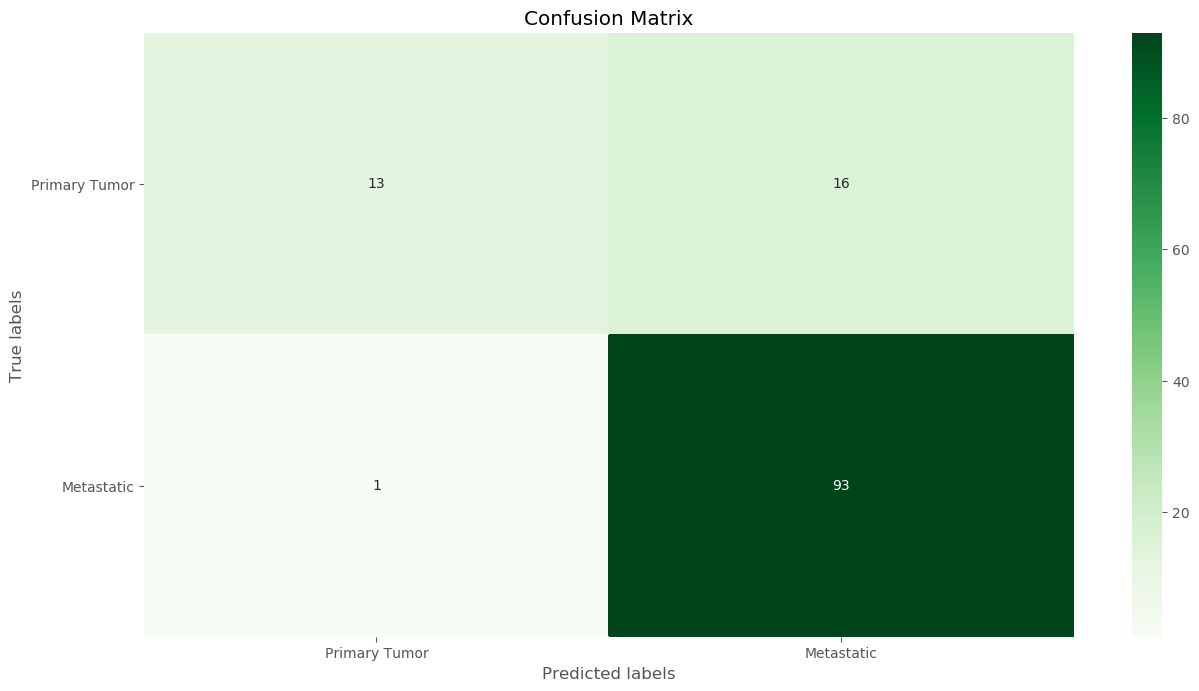

In [12]:
model_classifier.classifier_metrics(ensemble_all_clf, confusion_matrix = True)

In [13]:
joblib.dump(ensemble_all_clf, 'melanoma_ensemble_classifier.pkl', compress=9)

['melanoma_ensemble_classifier.pkl']

In [14]:
ensemble_sig_clf.fit(model_classifier.train_features, model_classifier.train_labels)

EnsembleVoteClassifier(clfs=[Pipeline(steps=[('columnselector',
                                              ColumnSelector(cols=('C7',
                                                                   'KRT17',
                                                                   'CLEC2A',
                                                                   'S100A7A',
                                                                   'KRTDAP',
                                                                   'WFDC5',
                                                                   'KRT6B',
                                                                   'S100A7',
                                                                   'KRT14',
                                                                   'PVRL4'))),
                                             ('pipeline',
                                              Pipeline(steps=[('scaler',
                                        


Training Performance:
AUC score: 0.9154074473826227
LogLoss score: 0.37806288729080556
Accuracy: 0.8321678321678322
f1 macro: 0.6995798319327731
f1 micro: 0.8321678321678322
f1 weighted: 0.8042545689604513
Precision macro: 0.8282239771465288
Precision micro: 0.8282239771465288
Precision weighted: 0.8282239771465288
Recall macro: 0.6672962763086886
Recall micro: 0.8321678321678322
Recall weighted: 0.8321678321678322

Validation Performance:
AUC score: 0.9721203228173148
LogLoss score: 0.29292336840423916
Accuracy: 0.8699186991869918
f1 macro: 0.7785778577857786
f1 micro: 0.8699186991869918
f1 weighted: 0.8537317146348782
Precision macro: 0.8600804359107421
Precision micro: 0.8600804359107421
Precision weighted: 0.8600804359107421
Recall macro: 0.7360601614086574
Recall micro: 0.8699186991869918
Recall weighted: 0.8699186991869918


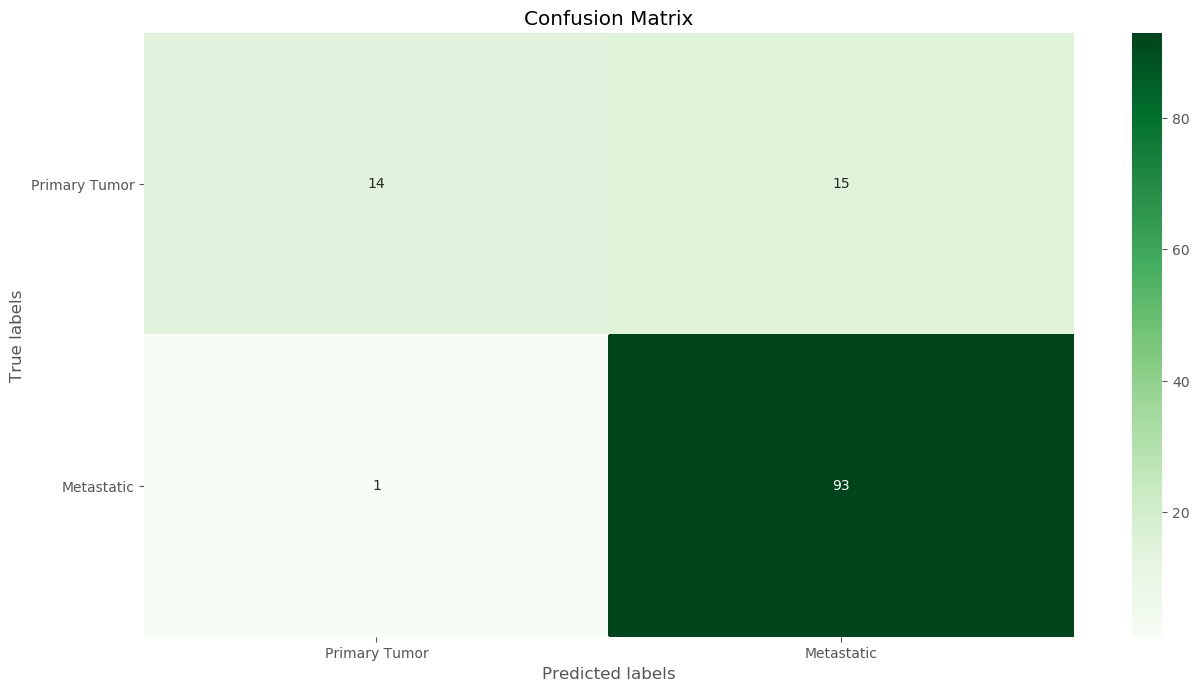

In [15]:
model_classifier.classifier_metrics(ensemble_sig_clf, confusion_matrix = True)

In [16]:
joblib.dump(ensemble_sig_clf, 'melanoma_ensemble_sig_classifier.pkl', compress=9)

['melanoma_ensemble_sig_classifier.pkl']

### Implicit Bias 

In [17]:
bias_df = pd.DataFrame(
    columns = [
                'rf_lr_10_model',
                'rf_svm_lin_10_model',
                'rf_svm_sig_30_model',
                'rf_nb_10_model',
                'rf_rf_20_model',
                'ppi_lr_10_model',
                'ppi_svm_lin_20_model',
                'ppi_svm_sig_10_model',
                'ppi_nb_20_model',
                'ensemble_all_clf',
                'ensemble_sig_clf'

            ],
    index   = ["age_0","age_20", "age_40", "age_60", "age_80", 
               "gender_male","gender_female",
               "bmi_normal","bmi_overweight","bmi_obese",
               "race_white","race_asian","race_not_reported",
               "ethnicity_hispanic","ethnicity_not_hispanic","ethnicity_not_reported"
              ]
)
bias_df

,rf_lr_10_model,rf_svm_lin_10_model,rf_svm_sig_30_model,rf_nb_10_model,rf_rf_20_model,ppi_lr_10_model,ppi_svm_lin_20_model,ppi_svm_sig_10_model,ppi_nb_20_model,ensemble_all_clf,ensemble_sig_clf
age_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender_male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender_female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi_normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi_overweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi_obese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def accuracy_with(biased_feature, model_pred, df):
    true_positive_1 = sum((df['sample_type']==1) & (df[model_pred]==1) & (df[biased_feature]==1))
    true_negative_1 = sum((df['sample_type']==0) & (df[model_pred]==0) & (df[biased_feature]==1))
    accuracy_1 = (true_positive_1 + true_negative_1) / sum(df[biased_feature]==1)
    
    true_positive_0 = sum((df['sample_type']==1) & (df[model_pred]==1) & (df[biased_feature]==0))
    true_negative_0 = sum((df['sample_type']==0) & (df[model_pred]==0) & (df[biased_feature]==0))
    accuracy_0 = (true_positive_0 + true_negative_0) / sum(df[biased_feature]==0)
    
    return accuracy_1, accuracy_0, sum(df[biased_feature]==1), sum(df[biased_feature]==0)

In [21]:
bias_check_df = test_df[[
        'vital_status_Dead', 
        'ethnicity_not hispanic or latino',
        'ethnicity_not reported', 
        'age_at_index', 
        'bmi']]

bias_check_df.insert(loc=5,  column='sample_type',          value = model_classifier.validation_labels)

bias_check_df.insert(loc=6,  column='rf_lr_10_model',       value = rf_lr_10_model.predict(model_classifier.validation_features[top10_rf_features]))
bias_check_df.insert(loc=7,  column='rf_svm_lin_10_model',  value = rf_svm_lin_10_model.predict(model_classifier.validation_features[top10_rf_features]))
bias_check_df.insert(loc=8,  column='rf_svm_sig_30_model',  value = rf_svm_sig_30_model.predict(model_classifier.validation_features[top30_rf_features]))
bias_check_df.insert(loc=9,  column='rf_nb_10_model',       value = rf_nb_10_model.predict(model_classifier.validation_features[top10_rf_features]))
bias_check_df.insert(loc=10, column='rf_rf_20_model',       value = rf_rf_20_model.predict(model_classifier.validation_features[top20_rf_features]))

bias_check_df.insert(loc=11, column='ppi_lr_10_model',      value = ppi_lr_10_model.predict(model_classifier.validation_features[top10_ppi_features]))
bias_check_df.insert(loc=12, column='ppi_svm_lin_20_model', value = ppi_svm_lin_20_model.predict(model_classifier.validation_features[top20_ppi_features]))
bias_check_df.insert(loc=13, column='ppi_svm_sig_10_model', value = ppi_svm_sig_10_model.predict(model_classifier.validation_features[top10_ppi_features]))
bias_check_df.insert(loc=14, column='ppi_nb_20_model',      value = ppi_nb_20_model.predict(model_classifier.validation_features[top20_ppi_features]))

bias_check_df.insert(loc=15, column='ensemble_all_clf',     value = ensemble_all_clf.predict(model_classifier.validation_features))
bias_check_df.insert(loc=16, column='ensemble_sig_clf',     value = ensemble_sig_clf.predict(model_classifier.validation_features))


bias_check_df.insert(loc=17, column='age_0',     value=[int(age<20) for age in bias_check_df['age_at_index']])
bias_check_df.insert(loc=18, column='age_20',     value=[int(age>=20 and age<40) for age in bias_check_df['age_at_index']])
bias_check_df.insert(loc=19, column='age_40',     value=[int(age>=40 and age<60) for age in bias_check_df['age_at_index']])
bias_check_df.insert(loc=20, column='age_60',     value=[int(age>=60 and age<80) for age in bias_check_df['age_at_index']])
bias_check_df.insert(loc=21, column='age_80',     value=[int(age>=80) for age in bias_check_df['age_at_index']])

bias_check_df.insert(loc=22, column='gender_male',     value=[int(clinical_df.loc[bias_index,"gender"] == 'male') for bias_index in bias_check_df.index.values])
bias_check_df.insert(loc=23, column='gender_female',   value=[int(clinical_df.loc[bias_index,"gender"] == 'female') for bias_index in bias_check_df.index.values])

bias_check_df.insert(loc=23, column='ethnicity_hispanic',     value=[int(clinical_df.loc[bias_index,"ethnicity"] == 'hispanic or latino') for bias_index in bias_check_df.index.values])
bias_check_df.insert(loc=25, column='ethnicity_not_hispanic', value=[int(clinical_df.loc[bias_index,"ethnicity"] == 'not hispanic or latino') for bias_index in bias_check_df.index.values])
bias_check_df.insert(loc=26, column='ethnicity_not_reported', value=[int(clinical_df.loc[bias_index,"ethnicity"] == 'not reported') for bias_index in bias_check_df.index.values])

bias_check_df.insert(loc=27, column='race_white', value=[int(clinical_df.loc[bias_index,"race"] == 'white') for bias_index in bias_check_df.index.values])
bias_check_df.insert(loc=28, column='race_asian', value=[int(clinical_df.loc[bias_index,"race"] == 'asian') for bias_index in bias_check_df.index.values])
bias_check_df.insert(loc=29, column='race_not_reported', value=[int(clinical_df.loc[bias_index,"race"] == 'not reported') for bias_index in bias_check_df.index.values])

bias_check_df.insert(loc=30, column='bmi_normal',     value=[int(bmi>=18.5 and bmi<25) for bmi in bias_check_df['bmi']])
bias_check_df.insert(loc=31, column='bmi_overweight', value=[int(bmi>=25 and bmi<30) for bmi in bias_check_df['bmi']])
bias_check_df.insert(loc=32, column='bmi_obese',      value=[int(bmi>=30) for bmi in bias_check_df['bmi']])

bias_check_df

,vital_status_Dead,ethnicity_not hispanic or latino,ethnicity_not reported,age_at_index,bmi,sample_type,rf_lr_10_model,rf_svm_lin_10_model,rf_svm_sig_30_model,rf_nb_10_model,rf_rf_20_model,ppi_lr_10_model,ppi_svm_lin_20_model,ppi_svm_sig_10_model,ppi_nb_20_model,ensemble_all_clf,ensemble_sig_clf,age_0,age_20,age_40,age_60,age_80,gender_male,ethnicity_hispanic,gender_female,ethnicity_not_hispanic,ethnicity_not_reported,race_white,race_asian,race_not_reported,bmi_normal,bmi_overweight,bmi_obese
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-D3-A8GE,0,0,0,26.0,31.314566,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1
TCGA-D9-A4Z3,0,1,0,73.0,24.221453,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0
TCGA-YD-A89C,0,1,0,43.0,21.936347,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0
TCGA-DA-A1I0,1,1,0,63.0,27.870572,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0
TCGA-EB-A5UL,0,1,0,71.0,23.888441,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0
TCGA-EE-A2M8,1,1,0,54.0,30.491604,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1
TCGA-ER-A2NG,1,1,0,43.0,29.198535,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0
TCGA-ER-A196,0,1,0,64.0,33.776427,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1
TCGA-Z2-AA3S,0,1,0,58.0,26.365603,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0


In [22]:
def set_accuracy(df, biased_field, model_field, percentage = False):
    tp = sum((df['sample_type'] == 1) & (df[model_field] == 1) & (df[biased_field] == 1))
    tn = sum((df['sample_type'] == 0) & (df[model_field] == 0) & (df[biased_field] == 1))
    N =  sum(df[biased_field] == 1)
    
    if percentage == False:
        return (tp + tn)
    else:
        return (tp + tn)/N

In [23]:
def set_N(df, biased_field):
    N =  sum(df[biased_field] == 1)
    return N

In [24]:
for model in bias_df.columns.values:
    for field in bias_df.index.values:
        bias_df.loc[field, model] = set_accuracy(bias_check_df, field, model, True)

In [25]:
bias_N_df = bias_df.copy()

for model in bias_df.columns.values:
    for field in bias_df.index.values:
        bias_N_df.loc[field, model] = set_N(bias_check_df, field)

In [26]:
bias_df

,rf_lr_10_model,rf_svm_lin_10_model,rf_svm_sig_30_model,rf_nb_10_model,rf_rf_20_model,ppi_lr_10_model,ppi_svm_lin_20_model,ppi_svm_sig_10_model,ppi_nb_20_model,ensemble_all_clf,ensemble_sig_clf
age_0,1,1,1,1,1,1,1,1,1,1,1
age_20,1,1,0.9375,1,1,1,1,0.9375,1,1,1
age_40,0.959184,0.918367,0.877551,0.918367,0.938776,0.918367,0.918367,0.877551,0.938776,0.918367,0.918367
age_60,0.851064,0.808511,0.829787,0.829787,0.893617,0.808511,0.808511,0.723404,0.829787,0.829787,0.829787
age_80,0.888889,0.444444,0.777778,0.555556,1,0.444444,0.444444,0.444444,0.555556,0.444444,0.555556
gender_male,0.921053,0.842105,0.855263,0.855263,0.947368,0.842105,0.842105,0.802632,0.868421,0.855263,0.855263
gender_female,0.914894,0.87234,0.87234,0.893617,0.914894,0.87234,0.87234,0.787234,0.893617,0.87234,0.893617
bmi_normal,0.871795,0.794872,0.794872,0.846154,0.948718,0.794872,0.794872,0.769231,0.820513,0.820513,0.846154
bmi_overweight,0.933333,0.866667,0.866667,0.866667,0.888889,0.866667,0.866667,0.777778,0.888889,0.866667,0.866667
bmi_obese,0.972973,0.918919,0.945946,0.918919,0.972973,0.918919,0.918919,0.891892,0.945946,0.918919,0.918919


In [27]:
bias_df.to_csv("../data/implicit_bias.csv")
bias_N_df.to_csv("../data/implicit_bias_N.csv")